In [1]:
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim

C:\Anaconda\envs\py3\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda\envs\py3\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda\envs\py3\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda\envs\py3\lib\site-packages\tensorflow\python\framework\dtypes.py:461: FutureWarning: Passing (type, 1) or 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
import sys
sys.path.append('../')

In [5]:
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

In [6]:
import pandas as pd
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

C:\Anaconda\envs\py3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [7]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

column_names = []
for i in range(0, 43):
    column_names.append("feature_" + str(i + 1))
column_names.append("output")

rd_csv = pd.read_csv("D:\\MasterThesis\\finalData.csv", names=column_names)

In [8]:
def model_MLPC2_20Fold():
    # get data
    X = rd_csv[column_names[0:43]]
    y = rd_csv[column_names[43]]
    scores = []
    # 数据预加工
    skf = StratifiedKFold(n_splits=20).split(X, y)
    cls = MLPClassifier(solver='lbfgs', activation='tanh',alpha=1e-3,
                        hidden_layer_sizes=(16, 64, 16), max_iter=1000)
    for train_index, test_index in skf:
        X_train_MLPC, X_test_MLPC = X.iloc[train_index], X.iloc[test_index]
        y_train_MLPC, y_test_MLPC = y.iloc[train_index], y.iloc[test_index]
        ss_MLPC = StandardScaler()
        X_train_MLPC = ss_MLPC.fit_transform(X_train_MLPC)
        X_test_MLPC = ss_MLPC.transform(X_test_MLPC)

        cls.fit(X_train_MLPC, y_train_MLPC)
        score_MLPC = cls.score(X_test_MLPC, y_test_MLPC)
        scores.append(score_MLPC)



    return (ss_MLPC)

In [9]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

In [10]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
# ckpt_filename = '../checkpoints/ssd_300_vgg.ckpt'
ckpt_filename = 'D:\\MasterThesis\\NailDetection\\nail_model\\model.ckpt-7246'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from D:\MasterThesis\NailDetection\nail_model\model.ckpt-7246


In [11]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

4


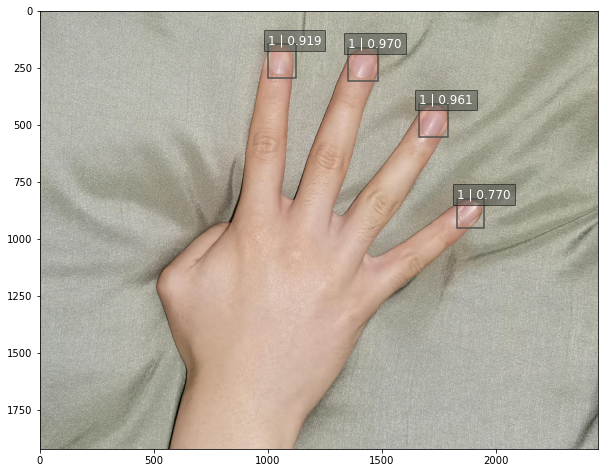

In [70]:
# Test on some demo image and visualize output.
# path = 'D:\\MasterThesis\\dataAndLabel\\'
path = 'D:\\MasterThesis\\test\\images\\'
item = '08'
image_name = item + '.jpg'
num = 1
img = mpimg.imread(path + image_name)
rclasses, rscores, rbboxes =  process_image(img)
print(len(rclasses))
nailLabel = len(rclasses)
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

In [71]:
import urllib.parse
import urllib.request
import base64
import json
import time

import os

def draw_hands_point(path, savePath, originfilename,hands,resultfilename,pointsize,pointcolor):
    from PIL import Image, ImageDraw
 
    image_origin = Image.open(path+originfilename)
    draw =ImageDraw.Draw(image_origin)
    
    for hand in hands:
        
        for hand_part in hand['hand_parts'].values():
            #print(hand_part)
            draw.ellipse((hand_part['x']-pointsize,hand_part['y']-pointsize,hand_part['x']+pointsize,hand_part['y']+pointsize),fill = pointcolor)
        gesture = hand['location'] 
        draw.rectangle((gesture['left'],gesture['top'],gesture['left']+gesture['width'],gesture['top']+gesture['height']),outline = "red")
    
    
    image_origin.save(savePath+"\\imgs\\"+resultfilename, "JPEG")


In [72]:
def hand_analysis(path, savePath, filename,resultfilename,pointsize,pointcolor):
    
    request_url = "https://aip.baidubce.com/rest/2.0/image-classify/v1/hand_analysis"
    print(filename)

    f = open(path+filename, 'rb')
    img = base64.b64encode(f.read())
    
    params = dict()
    params['image'] = img
    params = urllib.parse.urlencode(params).encode("utf-8")
    #params = json.dumps(params).encode('utf-8')
    
    # access_token = get_token()
    begin = time.perf_counter()
    """
    You need to input your own access_token
    """
    access_token = ''
    request_url = request_url + "?access_token=" + access_token
    request = urllib.request.Request(url=request_url, data=params)
    request.add_header('Content-Type', 'application/x-www-form-urlencoded')
    response = urllib.request.urlopen(request)
    content = response.read()
    end = time.perf_counter()
 
    print('Time:'+'%.2f'%(end-begin)+'s')
    if content:
        print(content)
        content=content.decode('utf-8')
        #print(content)
        data = json.loads(content)
        # print('hand_num:',data['hand_num'])
        # print('hand_info:',data['hand_info'])
        # print('hand_info:',data['hand_info'])
        #print(data)
        result=data['hand_info']

        file = list(filename.split('.'))
        file.remove(file[1])
        txtName = ''.join(file)
        with open(savePath+"\\informations\\"+txtName+".txt", "w") as fp:
            fp.write(json.dumps(result, indent=4))
        f.close()
        
        draw_hands_point(path, savePath, filename,result,resultfilename,pointsize,pointcolor)

In [73]:
savePath = "D:\\MasterThesis\\test\\"

hand_analysis(path, savePath, image_name, image_name, 20,'#800080')

08.jpg
Time:11.21s
b'{"log_id": 6213164949566252461, "hand_num": 1, "hand_info": [{"hand_parts": {"11": {"y": 402, "x": 1331, "score": 0.8446105122566223}, "10": {"y": 631, "x": 1265, "score": 0.8578460216522217}, "13": {"y": 1155, "x": 1265, "score": 0.7551062703132629}, "12": {"y": 173, "x": 1429, "score": 0.8943747282028198}, "15": {"y": 631, "x": 1626, "score": 0.8656315207481384}, "14": {"y": 828, "x": 1495, "score": 0.869193434715271}, "17": {"y": 1319, "x": 1364, "score": 0.7093384265899658}, "16": {"y": 435, "x": 1757, "score": 0.8893913626670837}, "19": {"y": 991, "x": 1757, "score": 0.8670109510421753}, "18": {"y": 1090, "x": 1626, "score": 0.8720327019691467}, "1": {"y": 1417, "x": 643, "score": 0.7183881402015686}, "0": {"y": 1712, "x": 905, "score": 0.6346114277839661}, "3": {"y": 959, "x": 774, "score": 0.820527970790863}, "2": {"y": 1155, "x": 578, "score": 0.7979485392570496}, "5": {"y": 991, "x": 938, "score": 0.7228291630744934}, "4": {"y": 1024, "x": 971, "score": 0.

In [74]:
txt_name = item + '.txt'
txtPath = 'D:\\MasterThesis\\test\\informations\\'
f = open(txtPath+txt_name,"r",encoding="utf-8") 
data = json.load(f)
keyPoints = data[0].get('hand_parts')
data_raw = []
for i in range(21):
    coordinates = keyPoints.get(str(i))
    data_raw.append(int(coordinates.get('x')))
    data_raw.append(int(coordinates.get('y')))
data_raw.append(nailLabel)

In [75]:
print(data_raw)

[905, 1712, 643, 1417, 578, 1155, 774, 959, 971, 1024, 938, 991, 971, 598, 1036, 336, 1036, 173, 1134, 1057, 1265, 631, 1331, 402, 1429, 173, 1265, 1155, 1495, 828, 1626, 631, 1757, 435, 1364, 1319, 1626, 1090, 1757, 991, 1920, 860, 4]


In [76]:
MLPC = joblib.load("D:\\MasterThesis\\model_MLPC2_20Fold.m")
ss_MLPC = model_MLPC2_20Fold()
X_test_MLPC = ss_MLPC.transform([data_raw])
y_predict_MLPC = str(MLPC.predict(X_test_MLPC)[0])
print('Hand Position Category:', y_predict_MLPC)

C:\Anaconda\envs\py3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda\envs\py3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda\envs\py3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Hand Position Category: b
